In [1]:
import numpy as np 
import pandas as pd
import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(test.shape)

(867, 6)


In [3]:
train["posts"]
test["posts"]
X_train = train["posts"]
y_train = train[["is_T"]].values

X_test = test["posts"]

In [4]:
max_features=100000
maxlen=150
embed_size=300

In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [6]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [7]:
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(1, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [12]:
batch_size = 32
epochs = 2
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

In [13]:
filepath='best_for_T.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

In [14]:
model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)

Train on 7417 samples, validate on 391 samples
Epoch 1/2
7417/7417 [==============================] - 169s 23ms/step - loss: 0.6457 - accuracy: 0.6211 - val_loss: 0.5801 - val_accuracy: 0.6854

 ROC-AUC - epoch: 1 - score: 0.762451

Epoch 00001: val_accuracy improved from -inf to 0.68542, saving model to best_for_T.hdf5
Epoch 2/2
7417/7417 [==============================] - 161s 22ms/step - loss: 0.5816 - accuracy: 0.6946 - val_loss: 0.5636 - val_accuracy: 0.7033

 ROC-AUC - epoch: 2 - score: 0.778512

Epoch 00002: val_accuracy improved from 0.68542 to 0.70332, saving model to best_for_T.hdf5


In [15]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [16]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

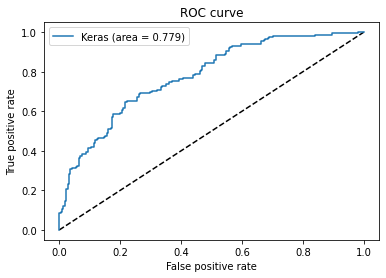

In [17]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()